In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy.stats import pearsonr

# Define the FeatureProcessor class
class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name='train.xlsx'):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)
        self.combined_features, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) - 1  # 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_Site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = np.array(list(one_hot_features), dtype=np.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        index_one_hot_tensor = np.array(index_one_hot_features, dtype=np.float32)[:, :, np.newaxis]

        combined_features = np.concatenate((features_tensor, index_one_hot_tensor), axis=2)
        return combined_features, sequence_length

    def label(self):
        labels_tensor = self.df['a-to-g(%)'].values / 100  # Normalize to [0, 1]
        return labels_tensor

# Load the dataset and process features
file_path = 'D:/01IscBML/'
train_file_name = 'train_del_keep1700.xlsx'
test_file_name = 'test_del_keep1700.xlsx'
train_processor = FeatureProcessor(file_path=file_path, file_name=train_file_name)
test_processor = FeatureProcessor(file_path=file_path, file_name=test_file_name)
# Extract features and labels
train_features = train_processor.combined_features.reshape(train_processor.combined_features.shape[0], -1)
train_labels = train_processor.labels_tensor

test_features = test_processor.combined_features.reshape(test_processor.combined_features.shape[0], -1)
test_labels = test_processor.labels_tensor

# Split data into training and testing sets

X_train, X_test = train_features, test_features
y_train, y_test = train_labels, test_labels


print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (11456, 280)
y_train shape: (11456,)
X_test shape: (2864, 280)
y_test shape: (2864,)


In [6]:
# Train the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=100,verbose_eval=True)

# Predict on the test set
y_pred = model.predict(dtest)

# Calculate Pearson correlation coefficient
pearson_corr, p_value = pearsonr(y_test, y_pred)

# Output results
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.4f}")

y_test_array = dtest.get_label()

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({
    'Actual': y_test_array,
    'Predicted': y_pred
})

# Save to a CSV file
results.to_csv('xgboost_y_test_y_pred.csv', index=False)


Pearson Correlation Coefficient: 0.7313
p-value: 0.0000


pearson_corr2: 0.7313096039111897
spearmanr_corr 0.7509699938020099


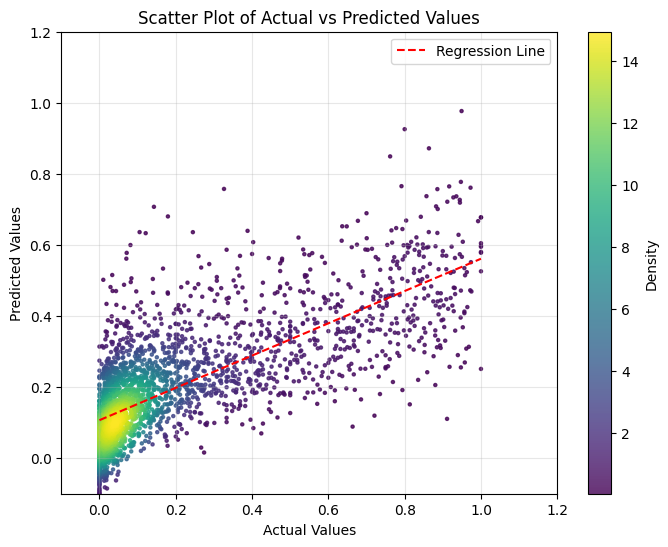

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import spearmanr

results = pd.read_csv('xgboost_y_test_y_pred.csv')
# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(8, 6))



y_test = results['Actual'].values
y_pred = results['Predicted'].values
pearson_corr2, p_value = pearsonr(y_test, y_pred)
spearmanr_corr2, p_value = spearmanr(y_test, y_pred)
print("pearson_corr2:", pearson_corr2)
print("spearmanr_corr",spearmanr_corr2)

# Calculate density for better visualization
xy = np.vstack([y_test, y_pred])
density = gaussian_kde(xy)(xy)

# Sort by density for a cleaner scatter plot
sorted_indices = density.argsort()
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
density_sorted = density[sorted_indices]

# Create scatter plot with density coloring
scatter = plt.scatter(
    y_test_sorted,
    y_pred_sorted,
    c=density_sorted,
    cmap='viridis',
    s=5,
    alpha=0.8
)

# Add a colorbar to indicate density
plt.colorbar(scatter, label='Density')

# Add regression line
plt.plot(
    np.unique(y_test),
    np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)),
    color='red',
    linestyle='--',
    label='Regression Line'
)

# Add titles and labels
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(-0.1, 1.2)
plt.ylim(-0.1, 1.2)
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()

pearson_corr2: 0.5769317609784633
spearmanr_corr 0.5650685268413582


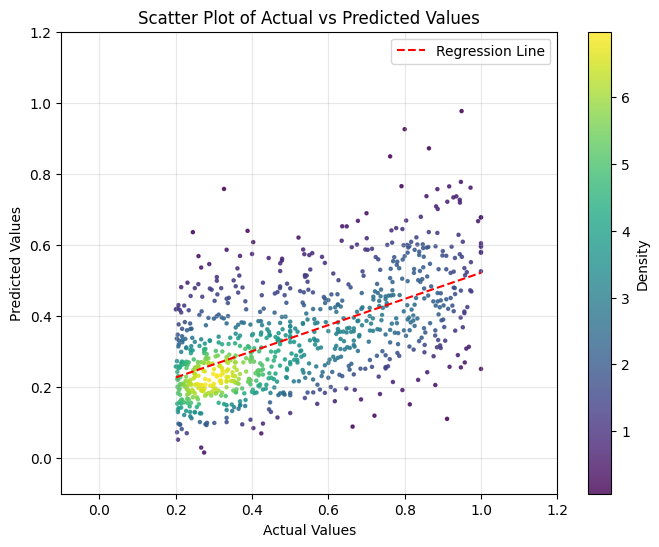

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr

results2 = pd.read_csv('xgboost_y_test_y_pred.csv')
results2 = results2[results2['Actual'] >0.2]
results2.to_csv('xgboost_y_test_y_pred_high.csv', index=False)

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(8, 6))

y_test_high = results2['Actual'].values
y_pred_high = results2['Predicted'].values

pearson_corr2, p_value = pearsonr(y_test_high, y_pred_high)
spearmanr_corr2, p_value = spearmanr(y_test_high, y_pred_high)
print("pearson_corr2:", pearson_corr2)
print("spearmanr_corr",spearmanr_corr2)

# Calculate density for better visualization
xy = np.vstack([y_test_high, y_pred_high])
density = gaussian_kde(xy)(xy)

# Sort by density for a cleaner scatter plot
sorted_indices = density.argsort()
y_test_sorted = y_test_high[sorted_indices]
y_pred_sorted = y_pred_high[sorted_indices]
density_sorted = density[sorted_indices]

# Create scatter plot with density coloring
scatter = plt.scatter(
    y_test_sorted,
    y_pred_sorted,
    c=density_sorted,
    cmap='viridis',
    s=5,
    alpha=0.8
)

# Add a colorbar to indicate density
plt.colorbar(scatter, label='Density')

# Add regression line
plt.plot(
    np.unique(y_test_high),
    np.poly1d(np.polyfit(y_test_high, y_pred_high, 1))(np.unique(y_test_high)),
    color='red',
    linestyle='--',
    label='Regression Line'
)

# Add titles and labels
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(-0.1, 1.2)
plt.ylim(-0.1, 1.2)
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()

[-1.11890368 -1.27555521  0.23355373 -0.15664153  0.68855474] [-0.32904451  1.55396259 -1.48298743  0.74554587  1.50126016]


(5, 1)